<a href="https://colab.research.google.com/github/merve-erdem01/merve-erdem/blob/main/hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols,adfuller
from sklearn.preprocessing import MinMaxScaler



from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install pmdarima
from pmdarima import auto_arima


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Colab Notebooks/continuous dataset.csv.zip'
csv_file_name = 'continuous dataset.csv'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/temp/')

df_data = pd.read_csv('/content/temp/continuous dataset.csv')


In [ ]:
df_data.replace('NULL', np.nan, inplace=True)

if 'datetime' in df_data.columns:
    df_data['datetime'] = pd.to_datetime(df_data['datetime'])
else:
    print("Warning: 'datetime' column not found in the XML data.")

if 'datetime' in df_data.columns:
    df_data['datetime'] = pd.to_datetime(df_data['datetime'])
else:
    print("Warning: 'datetime' column not found in the XML data.")

In [ ]:
df_data.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
df_data.shape

(48048, 17)

In [ ]:
df_data.isnull().sum()

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64

Non of them is empty so I don't need to eliminate any of NaN items or deal with this issue. This is a well conserved data set.

In [ ]:
# Convert 'datetime' column to datetime format
df_data['datetime'] = pd.to_datetime(df_data['datetime'])

# Set 'datetime' column as index
df_data.set_index('datetime', inplace=True)

In [ ]:
df_data.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
df_data=df_data.resample('D').sum()
df_data


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03,24593.1315,640.258344,0.427781,0.150905,519.569774,609.063031,0.418404,0.251831,255.940291,570.688031,0.391480,2.069977,100.681001,0,0,0
2015-01-04,24194.9663,657.257361,0.431690,0.090911,564.750271,630.007361,0.427456,0.329913,290.178945,580.687048,0.404308,2.509796,119.145686,0,0,0
2015-01-05,27520.3902,652.187445,0.429726,0.320255,642.616327,624.546820,0.416191,0.386194,340.907093,577.890570,0.388703,2.361938,172.331271,0,0,0
2015-01-06,27441.4663,648.086310,0.417367,0.260336,635.801032,621.828497,0.412217,0.364853,331.314068,571.476935,0.384289,2.327942,167.013520,0,0,0
2015-01-07,27458.3716,640.282080,0.413809,0.419168,573.518487,604.930518,0.399961,0.602199,312.988475,557.836768,0.369955,2.498993,167.628326,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,27296.7922,677.091223,0.499111,1.546936,217.434105,656.966223,0.480595,1.711655,73.531054,602.544348,0.463505,3.370636,79.165583,0,0,24
2020-06-24,27148.7190,671.086188,0.476302,1.643997,152.787257,646.508063,0.466818,1.618042,109.518611,595.242438,0.432677,2.500519,53.031454,0,0,24
2020-06-25,28416.6890,668.991095,0.488515,0.903442,345.535306,650.350470,0.466001,2.820801,85.825540,600.616095,0.432767,4.508881,49.275876,0,0,24


In [ ]:
df_data.select_dtypes(include='number').columns


Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [ ]:
numeric_columns=df_data.select_dtypes(include='number').columns
numeric_columns

Index(['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san',
       'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav',
       'W2M_dav', 'Holiday_ID', 'holiday', 'school'],
      dtype='object')

In [ ]:
for col in numeric_columns:
    df_data[col] = pd.to_numeric(df_data[col], errors='coerce')

df_data.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03,24593.1315,640.258344,0.427781,0.150905,519.569774,609.063031,0.418404,0.251831,255.940291,570.688031,0.391480,2.069977,100.681001,0,0,0
2015-01-04,24194.9663,657.257361,0.431690,0.090911,564.750271,630.007361,0.427456,0.329913,290.178945,580.687048,0.404308,2.509796,119.145686,0,0,0
2015-01-05,27520.3902,652.187445,0.429726,0.320255,642.616327,624.546820,0.416191,0.386194,340.907093,577.890570,0.388703,2.361938,172.331271,0,0,0
2015-01-06,27441.4663,648.086310,0.417367,0.260336,635.801032,621.828497,0.412217,0.364853,331.314068,571.476935,0.384289,2.327942,167.013520,0,0,0
2015-01-07,27458.3716,640.282080,0.413809,0.419168,573.518487,604.930518,0.399961,0.602199,312.988475,557.836768,0.369955,2.498993,167.628326,0,0,0


In [ ]:
df_data.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03,24593.1315,640.258344,0.427781,0.150905,519.569774,609.063031,0.418404,0.251831,255.940291,570.688031,0.391480,2.069977,100.681001,0,0,0
2015-01-04,24194.9663,657.257361,0.431690,0.090911,564.750271,630.007361,0.427456,0.329913,290.178945,580.687048,0.404308,2.509796,119.145686,0,0,0
2015-01-05,27520.3902,652.187445,0.429726,0.320255,642.616327,624.546820,0.416191,0.386194,340.907093,577.890570,0.388703,2.361938,172.331271,0,0,0
2015-01-06,27441.4663,648.086310,0.417367,0.260336,635.801032,621.828497,0.412217,0.364853,331.314068,571.476935,0.384289,2.327942,167.013520,0,0,0
2015-01-07,27458.3716,640.282080,0.413809,0.419168,573.518487,604.930518,0.399961,0.602199,312.988475,557.836768,0.369955,2.498993,167.628326,0,0,0


In [ ]:
# Replace missing values
df_data.fillna(0, inplace=True)

# Set the data frequency to hourly if not already set
df_data = df_data.resample('H').sum()

# Convert relevant columns to numeric
df_data['nat_demand'] = pd.to_numeric(df_data['nat_demand'], errors='coerce')

# Scale the data
scaler = MinMaxScaler()
df_data['nat_demand_scaled'] = scaler.fit_transform(df_data[['nat_demand']])

# Check data types
print(df_data.dtypes)

nat_demand           float64
T2M_toc              float64
QV2M_toc             float64
TQL_toc              float64
W2M_toc              float64
T2M_san              float64
QV2M_san             float64
TQL_san              float64
W2M_san              float64
T2M_dav              float64
QV2M_dav             float64
TQL_dav              float64
W2M_dav              float64
Holiday_ID             int64
holiday                int64
school                 int64
nat_demand_scaled    float64
dtype: object


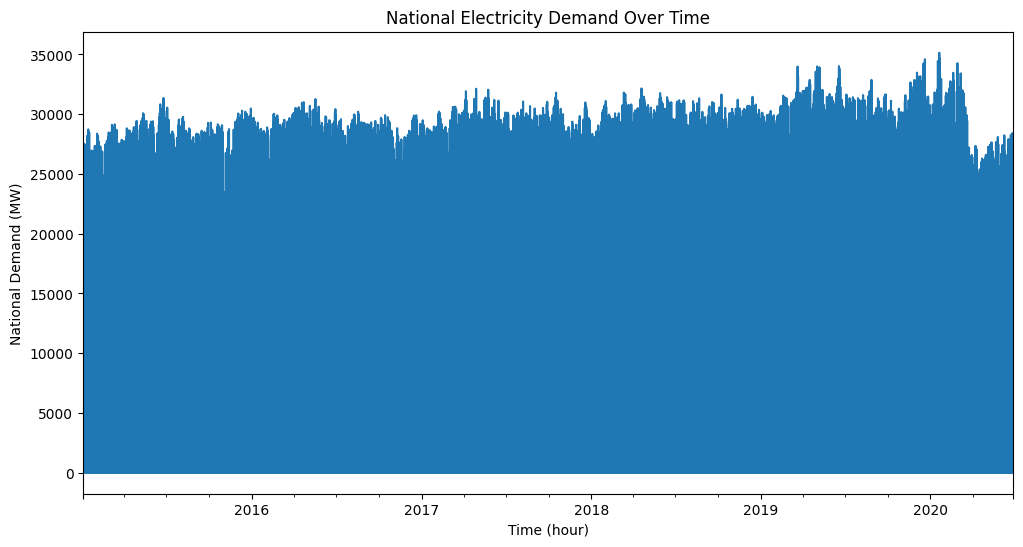

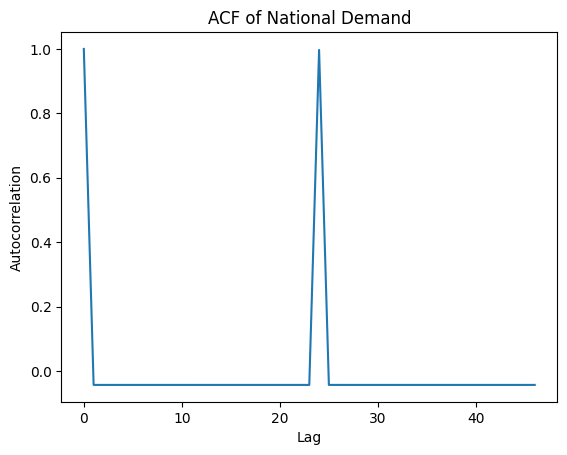

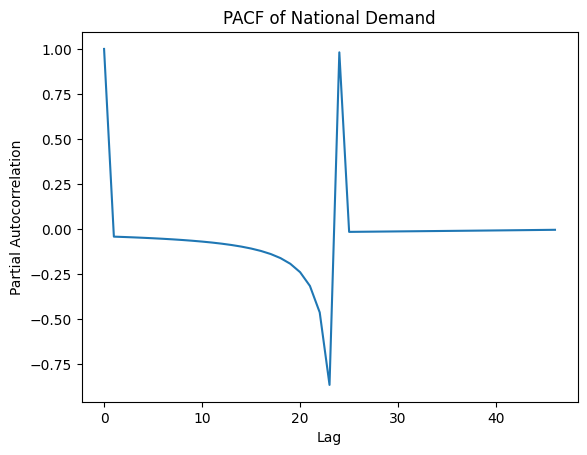

In [ ]:
# Plot the national demand over time
df_data['nat_demand'].plot(figsize=(12, 6))
plt.xlabel('Time (hour)')
plt.ylabel('National Demand (MW)')
plt.title('National Electricity Demand Over Time')
plt.show()

# Plot Autocorrelation Function (ACF)
plt.plot(acf(df_data['nat_demand']))
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of National Demand')
plt.show()

# Plot Partial Autocorrelation Function (PACF)
plt.plot(pacf(df_data['nat_demand']))
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF of National Demand')
plt.show()


In [ ]:
# Splitting the data into training and testing sets
dev_date = '2020-01-01'
train_data = df_data[:dev_date]
test_data = df_data[dev_date:]

train_data_scaled = train_data['nat_demand_scaled']
test_data_scaled = test_data['nat_demand_scaled']

In [ ]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

adf_test(df_data['nat_demand_scaled'], 'National Demand')


Augmented Dickey-Fuller Test: National Demand
ADF test statistic        -20.360595
p-value                     0.000000
# lags used                57.000000
# observations          47991.000000
critical value (1%)        -3.430486
critical value (5%)        -2.861600
critical value (10%)       -2.566802
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


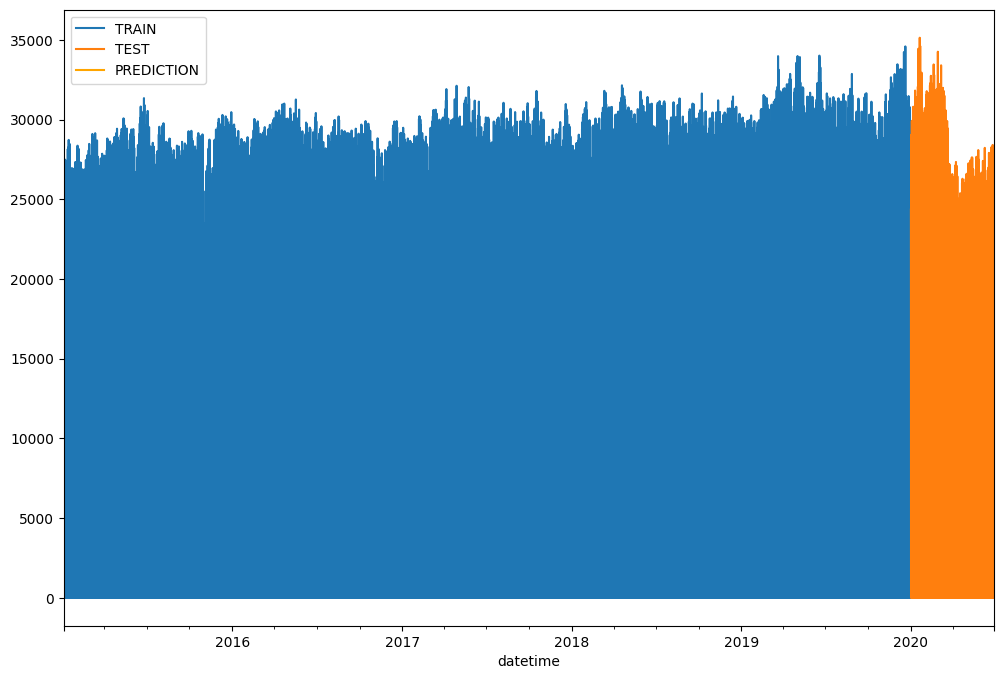

Mean Absolute Error: 83.12102532718107
Mean Squared Error: 262491.7734471993
Root Mean Squared Error: 512.3395099416005


In [ ]:
fitted_model = ExponentialSmoothing(train_data_scaled, trend='add', seasonal='add', seasonal_periods=24).fit()

# Forecast
number_of_days = 30
number_of_hours_to_predict = number_of_days * 24
end_date = pd.to_datetime(dev_date) + pd.Timedelta(hours=number_of_hours_to_predict - 1)
y = test_data_scaled[:number_of_hours_to_predict]
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')

# Inverse scaling
test_predictions_inverse = scaler.inverse_transform(test_predictions.values.reshape(-1, 1))
y_inverse = scaler.inverse_transform(y.values.reshape(-1, 1))

# Plot results
train_data['nat_demand'].plot(legend=True, label='TRAIN', figsize=(12, 8))
test_data['nat_demand'].plot(legend=True, label='TEST')
plt.plot(test_predictions.index, test_predictions_inverse, label='PREDICTION', color='orange')
plt.legend()
plt.show()

# Evaluate the model
mae = mean_absolute_error(y_inverse, test_predictions_inverse)
mse = mean_squared_error(y_inverse, test_predictions_inverse)
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)



In [ ]:

#Perform Fourier Transform
fft = np.fft.fft(df_data['nat_demand'].dropna())
fft_freq = np.fft.fftfreq(len(fft))

# Plot the Fourier Transform
plt.figure(figsize=(14, 7))
plt.plot(fft_freq, np.abs(fft))
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

In [ ]:

from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(df['nat_demand'], seasonal=13)
result_stl = stl.fit()

# Plot the STL components
result_stl.plot()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


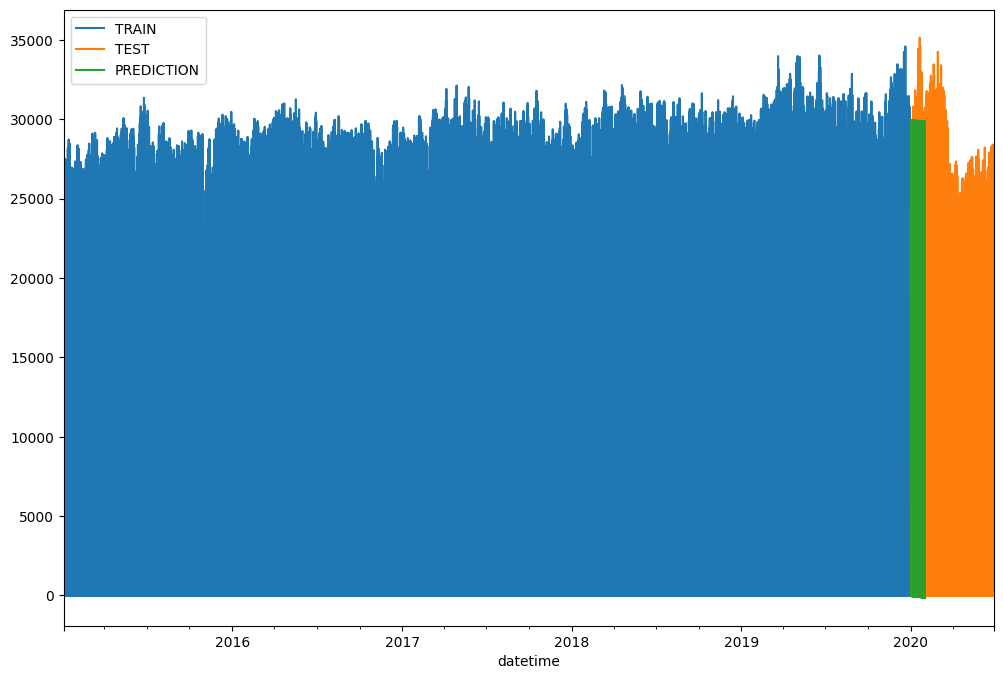

Mean Absolute Error: 173.53785384147295
Mean Squared Error: 273957.3352137539
Root Mean Squared Error: 523.4093381033184


In [ ]:
#Version without scaling, higher error rates

fitted_model = ExponentialSmoothing(train_data['nat_demand'], trend='add', seasonal='add', seasonal_periods=24).fit()

# Forecast
number_of_days = 30
number_of_hours_to_predict = number_of_days * 24
end_date = pd.to_datetime(dev_date) + pd.Timedelta(hours=number_of_hours_to_predict - 1)
y = test_data['nat_demand'][:number_of_hours_to_predict]
test_predictions = fitted_model.forecast(number_of_hours_to_predict).rename('HW_Forecast')

# Plot results
train_data['nat_demand'].plot(legend=True, label='TRAIN', figsize=(12, 8))
test_data['nat_demand'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

# Evaluate the model
mae = mean_absolute_error(y, test_predictions)
mse = mean_squared_error(y, test_predictions)
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

stepwise_fit = auto_arima(train_data['nat_demand'][:500],
                          start_p=0, start_q=0,
                          max_p=3, max_q=3,
                          seasonal=True,
                          m=24,
                          d=None,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit.summary()

# Create SARIMAX model
model = SARIMAX(train_data['nat_demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit()

# Forecast
forecasted_values = model_fit.forecast(steps=number_of_hours_to_predict)
forecasted_values.plot(legend=True, label='PREDICTION', figsize=(12, 8))
test_data['nat_demand'][:number_of_hours_to_predict].plot(legend=True, label='TEST')
plt.show()

# Evaluate the model
mae = mean_absolute_error(test_data['nat_demand'][:number_of_hours_to_predict], forecasted_values)
mse = mean_squared_error(test_data['nat_demand'][:number_of_hours_to_predict], forecasted_values)
rmse = np.sqrt(mse)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=16.63 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=7165.787, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=7155.806, Time=1.75 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=7156.831, Time=4.11 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=7163.828, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=7167.789, Time=0.36 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=7156.083, Time=5.14 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=15.89 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=7156.712, Time=1.62 sec
 ARIMA(1,0,0)(2,1,1)[24] intercept   : AIC=7155.747, Time=12.73 sec
 ARIMA(1,0,0)(2,1,2)[24] intercept   : AIC=inf, Time=50.99 sec
 ARIMA(1,0,0)(1,1,2)[24] intercept   : AIC=inf, Time=34.53 sec
 ARIMA(0,0,0)(2,1,1)[24] intercept   : AIC=7153.748, Time=8.33 sec
 ARIMA(0,0,0)(2,1,0)[24] intercept   : AIC=7154.082, Time=6.42 sec
 ARIMA(0,0,0)(2,1,2)[24] intercept

In [ ]:
final_model = SARIMAX(df_data['nat_demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)).fit()

# Setting the number of days for the forecast
days_forecast = 30
hours_forecast = days_forecast * 24

# Generating forecast predictions
forecast_predictions = final_model.forecast(steps=hours_forecast)

# Plot the last 100 data points in red and the forecast in blue
df_data['nat_demand'][-100:].plot(figsize=(12, 8), color='red', legend=True, label='Actual')
forecast_predictions.plot(color='blue', legend=True, label='Forecast')
plt.show()
